In [1]:
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# One single user repetition signal pre processing

In [2]:
# Load the user1 training data 
# Define paths (relative to notebook location)
BASE_PATH = Path("..") / "EMG-EPN612 Dataset"
TRAINING_PATH = BASE_PATH / "trainingJSON"
TESTING_PATH = BASE_PATH / "testingJSON"

print(f"Training path exists: {TRAINING_PATH.exists()}")
print(f"Testing path exists: {TESTING_PATH.exists()}")
print(f"Base path: {BASE_PATH.resolve()}")

# Load user1 JSON file
def load_user_json(split_path, user_folder):
    """Load a user's JSON file"""
    json_file = split_path / user_folder / f"{user_folder}.json"
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

# Load user1 from training split
user1_training_data = load_user_json(TRAINING_PATH, "user1")

# Load just idx_1 from trainingSamples
idx_1_sample = user1_training_data['trainingSamples']['idx_1']

gesture_name = idx_1_sample.get('gestureName')
print(f"\n✓ Loaded idx_1 sample")
print(f"  Gesture: {gesture_name}")
print(f"  Sample contains: {list(idx_1_sample.keys())}")

# Extract EMG channels and sampling rate
emg_data = idx_1_sample.get('emg', {})
emg_channels = {}
for i in range(1, 9):  # 8 channels: ch1 to ch8
    ch_name = f'ch{i}'
    if ch_name in emg_data:
        emg_channels[ch_name] = emg_data[ch_name]

sampling_rate_emg = 200  # Default sampling rate for EMG

print(f"\n✓ Extracted EMG channels:")
print(f"  - Number of channels: {len(emg_channels)}")
print(f"  - Sampling rate: {sampling_rate_emg} Hz")
for ch_name in sorted(emg_channels.keys()):
    print(f"  - {ch_name}: {len(emg_channels[ch_name])} samples")

Training path exists: True
Testing path exists: True
Base path: C:\Users\aless\Documents\EMG-EPN612 project\EMG-EPN612 Dataset

✓ Loaded idx_1 sample
  Gesture: noGesture
  Sample contains: ['startPointforGestureExecution', 'myoDetection', 'gestureName', 'quaternion', 'emg', 'gyroscope', 'accelerometer']

✓ Extracted EMG channels:
  - Number of channels: 8
  - Sampling rate: 200 Hz
  - ch1: 992 samples
  - ch2: 992 samples
  - ch3: 992 samples
  - ch4: 992 samples
  - ch5: 992 samples
  - ch6: 992 samples
  - ch7: 992 samples
  - ch8: 992 samples


## Signal Preprocessing: Filtering and Normalization

In [3]:

def preprocess_emg(emg_signal, fs=200, lowcut=20, highcut=500, notch_freq=50, notch_q=30):
    """
    Preprocess EMG signal: FIR bandpass (order 4) + notch (50 Hz) + normalization
    """
    # Bandpass FIR (order 4 -> numtaps=5)
    nyquist = fs / 2
    low = lowcut / nyquist
    high = min(highcut, nyquist * 0.99) / nyquist  # clamp to Nyquist

    low = max(0.001, min(low, 0.999))
    high = max(low + 0.001, min(high, 0.999))

    numtaps = 5  # order 4 FIR
    b_bp = signal.firwin(numtaps, [low, high], pass_zero=False)
    filtered = signal.filtfilt(b_bp, [1.0], emg_signal)

    # Notch filter at 50 Hz (IIR) + filtfilt
    b_notch, a_notch = signal.iirnotch(w0=notch_freq, Q=notch_q, fs=fs)
    filtered = signal.filtfilt(b_notch, a_notch, filtered)

    # Z-score normalization
    normalized = (filtered - np.mean(filtered)) / (np.std(filtered) + 1e-8)

    return filtered, normalized


# Preprocess all 8 channels
preprocessed_emg = {}
normalized_emg = {}

for ch_name, ch_data in emg_channels.items():
    filtered, normalized = preprocess_emg(np.array(ch_data))
    preprocessed_emg[ch_name] = filtered
    normalized_emg[ch_name] = normalized

print(f"✓ EMG Preprocessing Complete:")
print(f"  - Bandpass filter: 20-500 Hz")
print(f"  - Z-score normalization applied")
print(f"  - All 8 channels processed")

# Show comparison
ch1_original = np.array(emg_channels['ch1'])
ch1_normalized = normalized_emg['ch1']
print(f"\n  Channel 1 (ch1) - Before vs After:")
print(f"    Original:   Mean={np.mean(ch1_original):.4f}, Std={np.std(ch1_original):.4f}")
print(f"    Normalized: Mean={np.mean(ch1_normalized):.6f}, Std={np.std(ch1_normalized):.4f}")

✓ EMG Preprocessing Complete:
  - Bandpass filter: 20-500 Hz
  - Z-score normalization applied
  - All 8 channels processed

  Channel 1 (ch1) - Before vs After:
    Original:   Mean=-0.7308, Std=1.2260
    Normalized: Mean=-0.000000, Std=1.0000


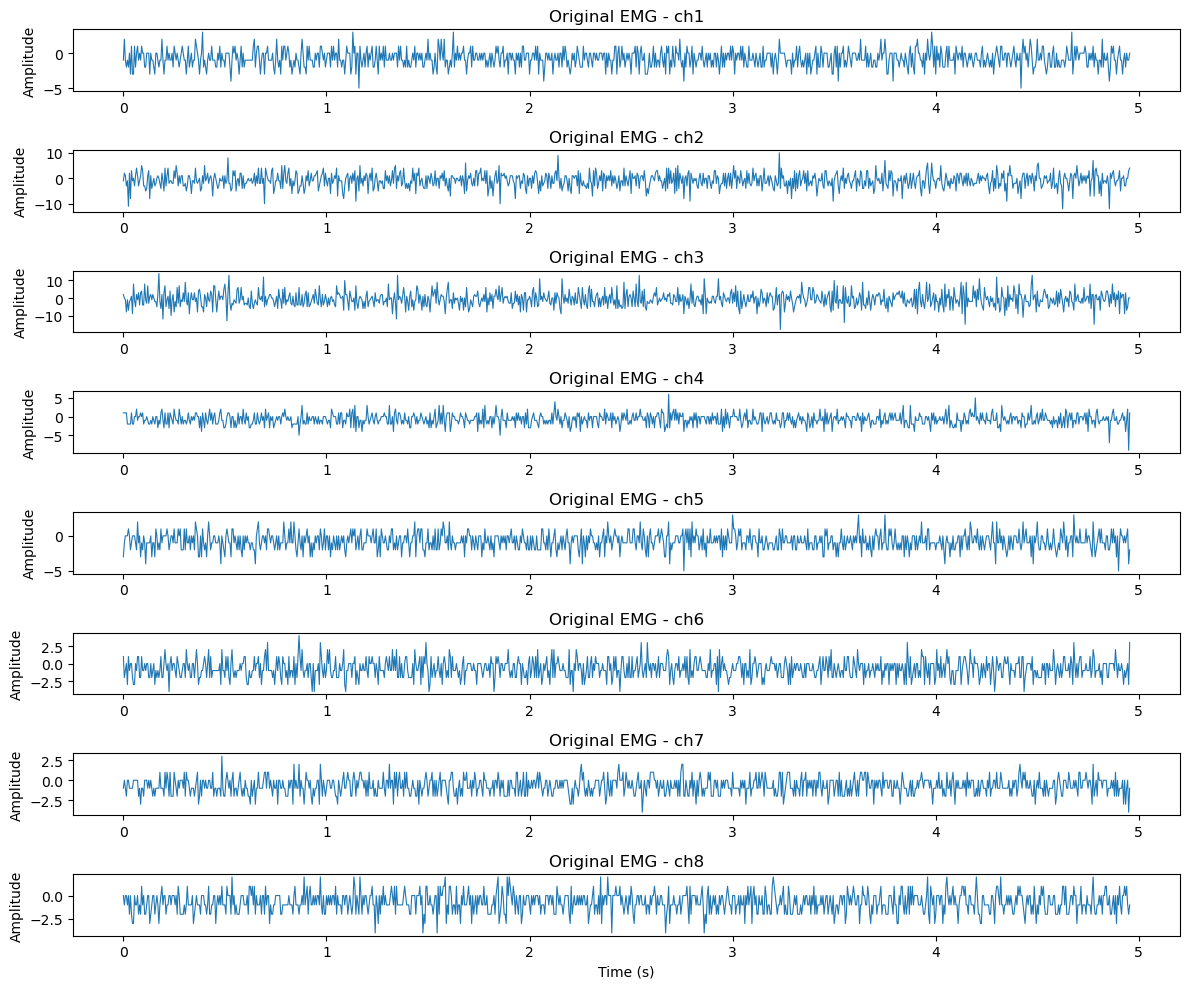

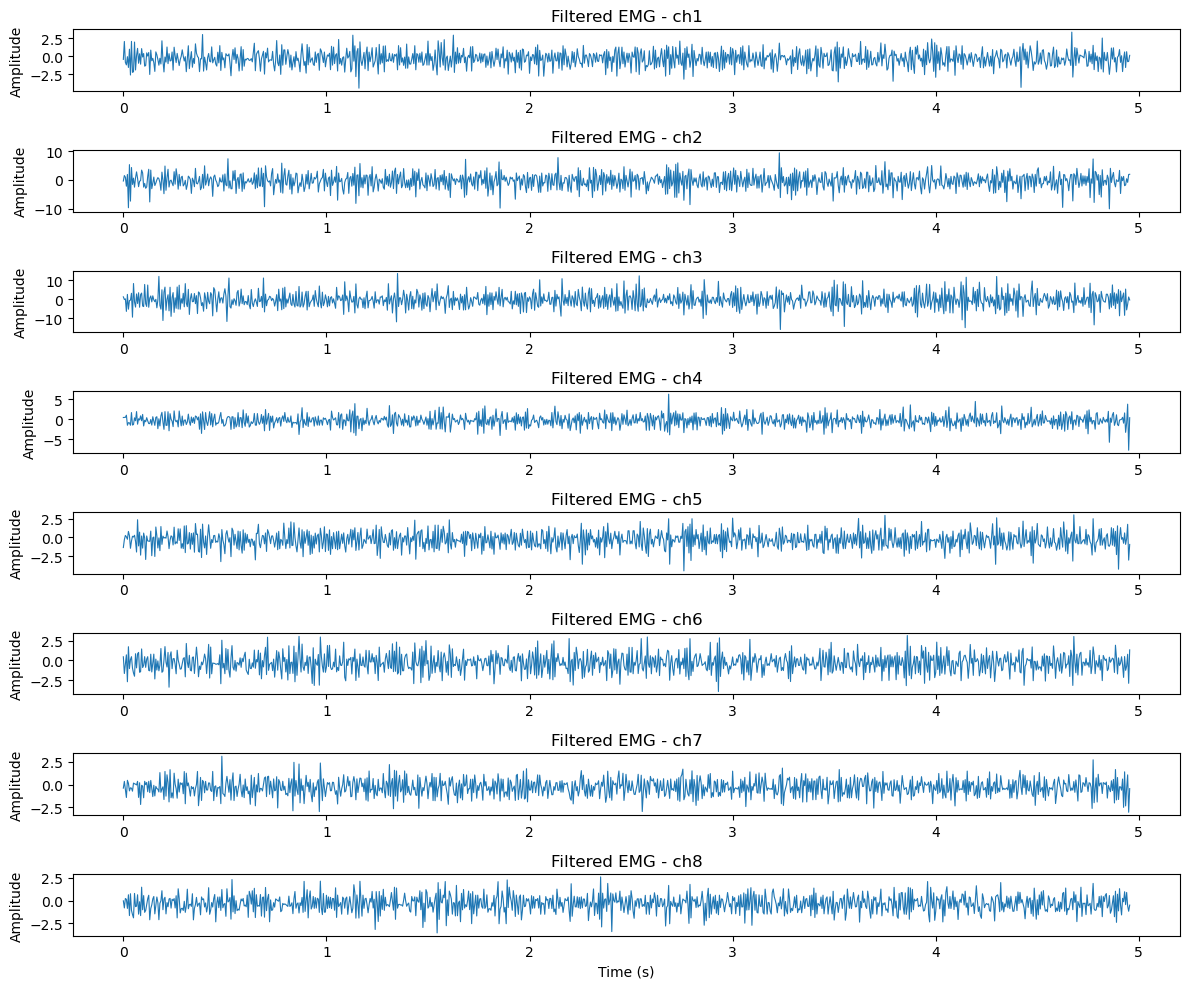

In [4]:
# Time axis
fs = sampling_rate_emg
n_samples = len(next(iter(emg_channels.values())))
t = np.arange(n_samples) / fs

# Plot original signals (all channels)
plt.figure(figsize=(12, 10))
for i, (ch_name, ch_data) in enumerate(emg_channels.items(), start=1):
    plt.subplot(8, 1, i)
    plt.plot(t, ch_data, linewidth=0.8)
    plt.title(f"Original EMG - {ch_name}")
    plt.ylabel("Amplitude")
    if i == 8:
        plt.xlabel("Time (s)")
    plt.tight_layout()
plt.show()

# Plot filtered signals (all channels)
plt.figure(figsize=(12, 10))
for i, (ch_name, ch_data) in enumerate(preprocessed_emg.items(), start=1):
    plt.subplot(8, 1, i)
    plt.plot(t, ch_data, linewidth=0.8)
    plt.title(f"Filtered EMG - {ch_name}")
    plt.ylabel("Amplitude")
    if i == 8:
        plt.xlabel("Time (s)")
    plt.tight_layout()
plt.show()


## Feature Extraction from EMG Signals

In [5]:
import numpy as np

# -----------------------------
# 1. LS — L-scale (Second L-moment λ2)
# -----------------------------
def LS(x):
    """
    Compute L-scale (second L-moment λ2)
    Robust dispersion measure
    """
    x = np.asarray(x)
    n = len(x)
    
    if n < 2:
        return 0.0
    
    x_sorted = np.sort(x)
    
    i = np.arange(1, n + 1)
    weights = (2 * i - n - 1)
    
    lambda2 = np.sum(weights * x_sorted) / (n * (n - 1))
    
    return lambda2


# -----------------------------
# 2. MFL — Maximum Fractal Length
# -----------------------------
def MFL(x, eps=1e-10):
    """
    Maximum Fractal Length
    """
    x = np.asarray(x)
    diff = np.diff(x)
    return np.log(np.sqrt(np.sum(diff ** 2)) + eps)


# -----------------------------
# 3. MSR — Mean Square Root
# -----------------------------
def MSR(x):
    """
    Mean Square Root
    """
    x = np.asarray(x)
    return np.mean(np.sqrt(np.abs(x)))


# -----------------------------
# 4. WAMP — Willison Amplitude
# -----------------------------
def WAMP(x, threshold=0.01):
    """
    Willison Amplitude
    """
    x = np.asarray(x)
    diff = np.abs(np.diff(x))
    return np.sum(diff > threshold)


# -----------------------------
# 5. ZC — Zero Crossings
# -----------------------------
def ZC(x, threshold=0.01):
    """
    Zero Crossings
    """
    x = np.asarray(x)
    x1 = x[:-1]
    x2 = x[1:]

    condition1 = (x1 * x2) < 0
    condition2 = np.abs(x1 - x2) > threshold

    return np.sum(condition1 & condition2)


# -----------------------------
# 6. RMS — Root Mean Square
# -----------------------------
def RMS(x):
    """
    Root Mean Square
    """
    x = np.asarray(x)
    return np.sqrt(np.mean(x ** 2))


# -----------------------------
# 7. IAV — Integrated Absolute Value
# -----------------------------
def IAV(x):
    """
    Integrated Absolute Value
    """
    x = np.asarray(x)
    return np.sum(np.abs(x))


# -----------------------------
# 8. DASDV — Difference Absolute Standard Deviation Value
# -----------------------------
def DASDV(x):
    """
    Difference Absolute Standard Deviation Value
    """
    x = np.asarray(x)
    diff = np.diff(x)
    return np.sqrt(np.mean(diff ** 2))


# -----------------------------
# 9. VAR — Variance
# -----------------------------
def VAR(x):
    """
    Variance
    """
    x = np.asarray(x)
    return np.var(x, ddof=1)


# -----------------------------
# Full TD9 Feature Extractor
# -----------------------------
def extract_TD9(x, threshold=0.01):
    """
    Extract all 9 time-domain EMG features
    """
    return {
        "LS": LS(x),
        "MFL": MFL(x),
        "MSR": MSR(x),
        "WAMP": WAMP(x, threshold),
        "ZC": ZC(x, threshold),
        "RMS": RMS(x),
        "IAV": IAV(x),
        "DASDV": DASDV(x),
        "VAR": VAR(x)
    }


# -----------------------------
# TD4 Feature Extractor
# -----------------------------
def extract_TD4(x, threshold=0.01):
    """
    Extract TD4 feature set
    """
    return {
        "LS": LS(x),
        "MFL": MFL(x),
        "MSR": MSR(x),
        "WAMP": WAMP(x, threshold)
    }

In [6]:
# Windowing and Feature Extraction
# Window length = 40 samples, Shift = 5 samples

window_length = 40
window_shift = 5

# Store all feature windows across all channels
all_features_list = []

# Process each channel
for ch_name, ch_data in normalized_emg.items():
    ch_data = np.array(ch_data)
    n_samples = len(ch_data)
    
    # Generate windows
    window_starts = range(0, n_samples - window_length + 1, window_shift)
    
    for start_idx in window_starts:
        end_idx = start_idx + window_length
        window = ch_data[start_idx:end_idx]
        
        # Extract TD9 features for this window
        features = extract_TD9(window, threshold=0.01)
        
        # Add channel name to identify which channel this came from
        features['Channel'] = ch_name
        features['Window_Start'] = start_idx
        
        all_features_list.append(features)

# Create DataFrame from all features
features_df = pd.DataFrame(all_features_list)

# Reorder columns for better readability
columns_order = ['Channel', 'Window_Start', 'LS', 'MFL', 'MSR', 'WAMP', 'ZC', 'RMS', 'IAV', 'DASDV', 'VAR']
features_df = features_df[columns_order]

print(f"✓ Feature Extraction Complete:")
print(f"  - Window length: {window_length} samples")
print(f"  - Window shift: {window_shift} samples")
print(f"  - Total windows extracted: {len(features_df)}")
print(f"  - Feature columns: {list(features_df.columns[2:])}")
print(f"\nFeature Table (first 10 rows):")
print(features_df.head(10))
print(f"\nFeature Table Statistics:")
print(features_df.describe())

✓ Feature Extraction Complete:
  - Window length: 40 samples
  - Window shift: 5 samples
  - Total windows extracted: 1528
  - Feature columns: ['LS', 'MFL', 'MSR', 'WAMP', 'ZC', 'RMS', 'IAV', 'DASDV', 'VAR']

Feature Table (first 10 rows):
  Channel  Window_Start        LS       MFL       MSR  WAMP  ZC       RMS  \
0     ch1             0  0.656040  2.502922  0.887957    39  28  1.123783   
1     ch1             5  0.658253  2.499690  0.901783    39  28  1.124113   
2     ch1            10  0.579775  2.348823  0.841976    39  28  0.996142   
3     ch1            15  0.515696  2.242121  0.790189    39  28  0.892911   
4     ch1            20  0.509665  2.210349  0.777767    39  26  0.884144   
5     ch1            25  0.529055  2.233915  0.771951    39  28  0.921464   
6     ch1            30  0.513724  2.214502  0.759796    39  27  0.892131   
7     ch1            35  0.516741  2.213213  0.756726    39  27  0.899346   
8     ch1            40  0.567551  2.308709  0.773937    38  26  1

In [7]:
## Compile Full Training Set (All Users)

In [ ]:
import json
import os
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import signal

# ── Paths ──────────────────────────────────────────────────────────────────────
BASE_PATH = Path("..") / "EMG-EPN612 Dataset"
TRAINING_PATH = BASE_PATH / "trainingJSON"

# ── Parameters ─────────────────────────────────────────────────────────────────
WINDOW_LENGTH = 40      # samples per window
WINDOW_SHIFT   = 5      # shift between consecutive windows
THRESHOLD      = 0.01   # WAMP / ZC threshold
CHANNELS       = [f"ch{i}" for i in range(1, 9)]   # ch1 … ch8
TD9_NAMES      = ["LS", "MFL", "MSR", "WAMP", "ZC", "RMS", "IAV", "DASDV", "VAR"]

# Build column names: ch1_LS, ch1_MFL, …, ch8_VAR  (72 features)
feature_columns = [f"{ch}_{feat}" for ch in CHANNELS for feat in TD9_NAMES]

# ── Helpers (reuse functions already defined above) ────────────────────────────
def _extract_td9_array(window, threshold=THRESHOLD):
    """Return TD9 features as a flat numpy array (length 9)."""
    return np.array([
        LS(window), MFL(window), MSR(window),
        WAMP(window, threshold), ZC(window, threshold),
        RMS(window), IAV(window), DASDV(window), VAR(window)
    ])

def process_single_sample(emg_dict, gesture_name, user_id, sample_id):
    """
    Preprocess + window + extract TD9 for one repetition.
    Returns a list of rows  [72 features + label + user + sample + window_start].
    """
    # Preprocess each channel → normalized signals
    norm_channels = {}
    for ch in CHANNELS:
        raw = np.array(emg_dict[ch])
        _, normalized = preprocess_emg(raw)          # defined in earlier cell
        norm_channels[ch] = normalized

    n_samples = len(norm_channels[CHANNELS[0]])
    rows = []

    for start in range(0, n_samples - WINDOW_LENGTH + 1, WINDOW_SHIFT):
        end = start + WINDOW_LENGTH
        feature_vec = []
        for ch in CHANNELS:
            window = norm_channels[ch][start:end]
            feature_vec.append(_extract_td9_array(window))
        # flatten 8×9 → 72
        feature_vec = np.concatenate(feature_vec)
        rows.append(np.append(feature_vec, [gesture_name, user_id, sample_id, start]))

    return rows

# ── Main loop over all users ──────────────────────────────────────────────────
user_folders = sorted(
    [d for d in os.listdir(TRAINING_PATH) if d.startswith("user")],
    key=lambda x: int(x.replace("user", ""))
)

all_rows = []
total_users = len(user_folders)

for idx, user_folder in enumerate(user_folders, 1):
    json_path = TRAINING_PATH / user_folder / f"{user_folder}.json"
    with open(json_path, "r") as f:
        user_data = json.load(f)

    samples = user_data.get("trainingSamples", {})

    for sample_key, sample in samples.items():
        gesture = sample["gestureName"]
        emg = sample["emg"]
        rows = process_single_sample(emg, gesture, user_folder, sample_key)
        all_rows.extend(rows)

    if idx % 50 == 0 or idx == total_users:
        print(f"  Processed {idx}/{total_users} users  |  rows so far: {len(all_rows)}")

# ── Build DataFrame ───────────────────────────────────────────────────────────
meta_columns = ["label", "user", "sample_id", "window_start"]
all_columns  = feature_columns + meta_columns

training_df = pd.DataFrame(all_rows, columns=all_columns)

# Cast feature columns to float
training_df[feature_columns] = training_df[feature_columns].astype(float)
training_df["window_start"]  = training_df["window_start"].astype(int)

print(f"\n✓ Training set compiled")
print(f"  Shape : {training_df.shape}")
print(f"  Features : {len(feature_columns)}  ({len(CHANNELS)} channels × {len(TD9_NAMES)} TD9)")
print(f"  Users : {training_df['user'].nunique()}")
print(f"  Samples per user : ~{len(samples)}")
print(f"  Label distribution:\n{training_df['label'].value_counts().to_string()}")
print(f"\nFirst 5 rows (features + label):")
training_df.head()

  Processed 50/306 users  |  rows so far: 1437190
  Processed 100/306 users  |  rows so far: 2870275
  Processed 150/306 users  |  rows so far: 4306883
  Processed 200/306 users  |  rows so far: 5740892


In [ ]:
# ── Separate features (X) and labels (y) ──────────────────────────────────────
X_train = training_df[feature_columns].values          # shape: (N, 72)
y_train = training_df["label"].values                   # shape: (N,)

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"Label mapping : {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"\nFeature columns ({len(feature_columns)}):")
print(feature_columns)